<a href="https://colab.research.google.com/github/dgsmith1988/ECSE-552-Final-Project/blob/achaebe/execution_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overall Script Description
Run through each of the different cells to get things working. What should happen is that you connect to Google Drive, some data is transferred and then unzipped and then the model is trained on it and outputs data indicating correct operation. On the Google Drive there should also be files added under "Measurements" which have a date and time-stamp corresponding to the output of training process. The time stamps are generated by the Google Colab instance so they won't match exactly with your local time depending on where the instance they supplied us is located.

The cells are broken up based on functionality to make it easier to debug/profile/troubleshoot any issues which might come up.

In [1]:
!pip install torchmetrics > /dev/null
!pip install pytorch-lightning > /dev/null
!pip install librosa > /dev/null
!pip install optuna > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


# Configure Directories/Paths/Languages
The following cell is where you configure which languages you want to work with (from the three which are available on Google Drive at the moment). It is also where you set the paths to where the Google Drive will be mounted and where the data is extracted to.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
languages = ["EN", "DE", "ES"]
mount_point = '/content/drive'
load_path = os.path.join(mount_point, 'MyDrive/ECSE-552-FP/Data/')
unzip_path = '/content/speech_data'
save_path = '/MyDrive/ECSE-552-FP/Measurements'

from google.colab import drive
drive.mount(mount_point,force_remount= True)

Mounted at /content/drive


# Download and extract the dataset zip files
The following downloads and extracts the language zip files from Google Drive. It is done separately in it's own cell to make it easier to profile/debug things if there are issues in the network connection between Google Drive and Google Colab. 

This is separate from dataset creation for two reasons. The first is that if the network accesses are obscured by accessing the data via the network drive, it is much harder to debug bottlenecks in creating the dataset. The second is that all of the data must be transferred once at somepoint during one epoch, so it's easier to do it all up front and make sure the data is on the Colab instance before training. Localizing as much as possible to the Colab instance during training makes things easier to debug as well as more efficient.

There is a commented out code which allows you to select between the "debug" dataset and the "full" dataset for the languages. The "debug" set consists of a smaller subset (20 samples for each language) to aid in debugging the dataflow in models. It alleviates the need to run through the entire dataset and helps ensure all the pipes are connected correctly.

In [4]:
for language in languages:
    language_dir_path = os.path.join(unzip_path, language)
    os.makedirs(language_dir_path, exist_ok=True)
    #archive = language + "_debug_set" + ".zip"
    archive = language + ".zip"
    !unzip {os.path.join(load_path, archive)} -d {language_dir_path} > /dev/null

# Download the source code from GitHub

In [5]:
user = "dgsmith1988"
repo = "ECSE-552-Final-Project"
src_dir = "Code"
pyfiles = ["models.py", "train.py", "dict_logger.py", "feature_extraction.py"]

for pyfile in pyfiles:
    !rm {pyfile}
    url = f"https://raw.githubusercontent.com/{user}/{repo}/achaebe/{src_dir}/{pyfile}"
    !wget {url} > /dev/null


rm: cannot remove 'models.py': No such file or directory
--2022-03-27 15:44:49--  https://raw.githubusercontent.com/dgsmith1988/ECSE-552-Final-Project/achaebe/Code/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5628 (5.5K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]   5.50K  --.-KB/s    in 0s      

2022-03-27 15:44:49 (64.6 MB/s) - ‘models.py’ saved [5628/5628]

rm: cannot remove 'train.py': No such file or directory
--2022-03-27 15:44:49--  https://raw.githubusercontent.com/dgsmith1988/ECSE-552-Final-Project/achaebe/Code/train.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserco

# Install the supporting/required libraries



# Hyperparameter tuning

In [6]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-666c7c9e-947f-39e9-b6d6-62509079d966)


In [ ]:
import optuna
import train

train.hp_tuning_voxforge_classifier(data_dir=unzip_path)

[I 2022-03-26 23:14:47,540] A new study created in memory with name: no-name-2039f00e-81de-451f-a166-0b3b6312227e
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Preparing and splitting dataset...


1601it [01:57, 13.60it/s]
1601it [02:02, 13.08it/s]
1601it [02:33, 10.46it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type     | Params
--------------------------------------------
0 | resnet50       | ResNet   | 25.6 M
1 | fc             | Linear   | 3.0 K 
2 | train_accuracy | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
4 | val_accuracy   | Accuracy | 0     
--------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.240   Total estimated model params size (MB)


Dataset creation in seconds:  393.22221763100015


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/Checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-03-26 23:26:42,093] Trial 0 finished with value: 0.938489556312561 and parameters: {'max_t': 5, 'batch_size': 161}. Best is trial 0 with value: 0.938489556312561.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Preparing and splitting dataset...


1601it [02:44,  9.75it/s]
1601it [01:35, 16.70it/s]
1601it [01:46, 15.00it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type     | Params
--------------------------------------------
0 | resnet50       | ResNet   | 25.6 M
1 | fc             | Linear   | 3.0 K 
2 | train_accuracy | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
4 | val_accuracy   | Accuracy | 0     
--------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.240   Total estimated model params size (MB)


Dataset creation in seconds:  366.779178282


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/Checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-03-26 23:36:29,289] Trial 1 finished with value: 0.9224749803543091 and parameters: {'max_t': 3, 'batch_size': 122}. Best is trial 0 with value: 0.938489556312561.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Preparing and splitting dataset...


1601it [02:33, 10.44it/s]
1601it [01:36, 16.62it/s]
1601it [01:47, 14.88it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type     | Params
--------------------------------------------
0 | resnet50       | ResNet   | 25.6 M
1 | fc             | Linear   | 3.0 K 
2 | train_accuracy | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
4 | val_accuracy   | Accuracy | 0     
--------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.240   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/Checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Dataset creation in seconds:  357.2955621139995


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-03-26 23:46:49,304] Trial 2 finished with value: 0.9113739728927612 and parameters: {'max_t': 3, 'batch_size': 50}. Best is trial 0 with value: 0.938489556312561.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Preparing and splitting dataset...


1601it [01:44, 15.28it/s]
1601it [01:36, 16.54it/s]
1601it [01:48, 14.81it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type     | Params
--------------------------------------------
0 | resnet50       | ResNet   | 25.6 M
1 | fc             | Linear   | 3.0 K 
2 | train_accuracy | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
4 | val_accuracy   | Accuracy | 0     
--------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.240   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/Checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Dataset creation in seconds:  309.6907611980005


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-03-26 23:55:41,817] Trial 3 finished with value: 0.9330300092697144 and parameters: {'max_t': 3, 'batch_size': 107}. Best is trial 0 with value: 0.938489556312561.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Preparing and splitting dataset...


1601it [01:46, 14.98it/s]
1601it [02:03, 12.97it/s]
1601it [02:20, 11.37it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type     | Params
--------------------------------------------
0 | resnet50       | ResNet   | 25.6 M
1 | fc             | Linear   | 3.0 K 
2 | train_accuracy | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
4 | val_accuracy   | Accuracy | 0     
--------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.240   Total estimated model params size (MB)


Dataset creation in seconds:  371.07339333300024


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/Checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-03-27 00:07:23,119] Trial 4 finished with value: 0.9468607902526855 and parameters: {'max_t': 5, 'batch_size': 78}. Best is trial 4 with value: 0.9468607902526855.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Preparing and splitting dataset...


1601it [01:51, 14.39it/s]
1601it [02:17, 11.68it/s]
1601it [02:48,  9.48it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type     | Params
--------------------------------------------
0 | resnet50       | ResNet   | 25.6 M
1 | fc             | Linear   | 3.0 K 
2 | train_accuracy | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
4 | val_accuracy   | Accuracy | 0     
--------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.240   Total estimated model params size (MB)


Dataset creation in seconds:  417.28004286600026


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/Checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-03-27 00:19:54,735] Trial 5 finished with value: 0.9303002953529358 and parameters: {'max_t': 5, 'batch_size': 74}. Best is trial 4 with value: 0.9468607902526855.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Preparing and splitting dataset...


1601it [01:42, 15.65it/s]
1601it [02:24, 11.07it/s]
1601it [02:38, 10.08it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type     | Params
--------------------------------------------
0 | resnet50       | ResNet   | 25.6 M
1 | fc             | Linear   | 3.0 K 
2 | train_accuracy | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
4 | val_accuracy   | Accuracy | 0     
--------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.240   Total estimated model params size (MB)


Dataset creation in seconds:  405.72463934200005


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/Checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-03-27 00:31:04,814] Trial 6 finished with value: 0.9339399337768555 and parameters: {'max_t': 3, 'batch_size': 50}. Best is trial 4 with value: 0.9468607902526855.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Preparing and splitting dataset...


1601it [02:26, 10.91it/s]
1601it [02:03, 12.93it/s]
1601it [02:18, 11.53it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type     | Params
--------------------------------------------
0 | resnet50       | ResNet   | 25.6 M
1 | fc             | Linear   | 3.0 K 
2 | train_accuracy | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
4 | val_accuracy   | Accuracy | 0     
--------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.240   Total estimated model params size (MB)


Dataset creation in seconds:  409.37747661899994


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/Checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-03-27 00:43:20,770] Trial 7 finished with value: 0.8564149141311646 and parameters: {'max_t': 5, 'batch_size': 182}. Best is trial 4 with value: 0.9468607902526855.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Preparing and splitting dataset...


1601it [01:49, 14.58it/s]
1601it [01:38, 16.20it/s]
1601it [01:49, 14.60it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type     | Params
--------------------------------------------
0 | resnet50       | ResNet   | 25.6 M
1 | fc             | Linear   | 3.0 K 
2 | train_accuracy | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
4 | val_accuracy   | Accuracy | 0     
--------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.240   Total estimated model params size (MB)


Dataset creation in seconds:  318.28114443600043


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/Checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-03-27 00:52:39,238] Trial 8 finished with value: 0.9232029318809509 and parameters: {'max_t': 3, 'batch_size': 69}. Best is trial 4 with value: 0.9468607902526855.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Preparing and splitting dataset...


1601it [01:52, 14.29it/s]
1601it [01:49, 14.61it/s]
1601it [02:00, 13.23it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type     | Params
--------------------------------------------
0 | resnet50       | ResNet   | 25.6 M
1 | fc             | Linear   | 3.0 K 
2 | train_accuracy | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
4 | val_accuracy   | Accuracy | 0     
--------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.240   Total estimated model params size (MB)


Dataset creation in seconds:  342.65910349000114


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/Checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-03-27 01:02:01,438] Trial 9 finished with value: 0.9324840903282166 and parameters: {'max_t': 3, 'batch_size': 110}. Best is trial 4 with value: 0.9468607902526855.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Preparing and splitting dataset...


1601it [02:27, 10.82it/s]
1601it [02:11, 12.15it/s]
1601it [02:23, 11.17it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type     | Params
--------------------------------------------
0 | resnet50       | ResNet   | 25.6 M
1 | fc             | Linear   | 3.0 K 
2 | train_accuracy | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
4 | val_accuracy   | Accuracy | 0     
--------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.240   Total estimated model params size (MB)


Dataset creation in seconds:  423.11324520199923


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/Checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-03-27 01:14:22,074] Trial 10 finished with value: 0.888808012008667 and parameters: {'max_t': 4, 'batch_size': 42}. Best is trial 4 with value: 0.9468607902526855.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Preparing and splitting dataset...


1601it [02:15, 11.83it/s]
1601it [02:23, 11.13it/s]
1601it [02:39, 10.02it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type     | Params
--------------------------------------------
0 | resnet50       | ResNet   | 25.6 M
1 | fc             | Linear   | 3.0 K 
2 | train_accuracy | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
4 | val_accuracy   | Accuracy | 0     
--------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.240   Total estimated model params size (MB)


Dataset creation in seconds:  439.1151748989996


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/Checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-03-27 01:26:42,141] Trial 11 finished with value: 0.917561411857605 and parameters: {'max_t': 5, 'batch_size': 237}. Best is trial 4 with value: 0.9468607902526855.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Preparing and splitting dataset...


1601it [02:01, 13.20it/s]
1601it [02:12, 12.09it/s]
1601it [02:26, 10.90it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type     | Params
--------------------------------------------
0 | resnet50       | ResNet   | 25.6 M
1 | fc             | Linear   | 3.0 K 
2 | train_accuracy | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
4 | val_accuracy   | Accuracy | 0     
--------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.240   Total estimated model params size (MB)


Dataset creation in seconds:  400.60212118600066


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/Checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-03-27 01:37:57,592] Trial 12 finished with value: 0.9310281872749329 and parameters: {'max_t': 4, 'batch_size': 157}. Best is trial 4 with value: 0.9468607902526855.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Preparing and splitting dataset...


1333it [02:12,  1.54it/s]

# Run/Train the Model

Preparing and splitting dataset...


1601it [01:57, 13.59it/s]
1601it [02:25, 11.00it/s]
1601it [03:26,  7.74it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type     | Params
--------------------------------------------
0 | resnet50       | ResNet   | 25.6 M
1 | fc             | Linear   | 3.0 K 
2 | train_accuracy | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
4 | val_accuracy   | Accuracy | 0     
--------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.240   Total estimated model params size (MB)


Dataset creation in seconds:  470.3056113439998
Running on Colab
Initializing trainer...
Running model...


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/DictLogger/0.1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

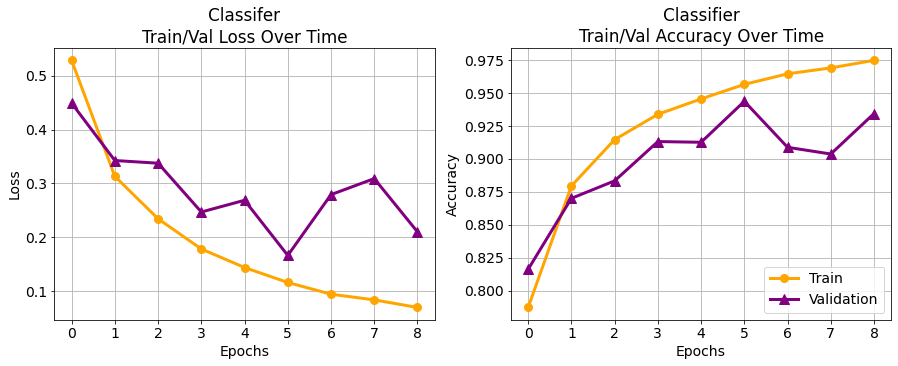

In [14]:
import train
from models import BaselineResnetClassifier

model = BaselineResnetClassifier(num_classes=3)
train.train_voxforge_classifier(model, data_dir=unzip_path, max_epoch=20,
                                batch_size=128, dur_seconds=5)

# Save model to Google Drive

In [ ]:
# When a model needs to be saved for future analysis, it must be moved to Google drive, since colab is not-persistent

In [ ]:
# First, download the move_checkpoint.py script
user = "dgsmith1988"
repo = "ECSE-552-Final-Project"
src_dir = "Code"
pyfiles = ["move_checkpoint.py"]

for pyfile in pyfiles:
    !rm {pyfile}
    url = f"https://raw.githubusercontent.com/{user}/{repo}/rubert/{src_dir}/{pyfile}"
    !wget {url}

rm: cannot remove 'move_checkpoint.py': No such file or directory
--2022-03-19 16:44:25--  https://raw.githubusercontent.com/dgsmith1988/ECSE-552-Final-Project/rubert/Code/move_checkpoint.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1420 (1.4K) [text/plain]
Saving to: ‘move_checkpoint.py’

move_checkpoint.py  100%[===================>]   1.39K  --.-KB/s    in 0s      

2022-03-19 16:44:25 (23.8 MB/s) - ‘move_checkpoint.py’ saved [1420/1420]



In [ ]:
# NExt, move the desired file, and assigne a new meanigful_name. 
# it will be properly stored in the folder Checkpoints
from move_checkpoint import move_checkpoint
move_checkpoint(r'/content/DictLogger/0.1/checkpoints/epoch=4-step=10989.ckpt', 'first_step')

Running on Colab


In [ ]:
# TODO: which hyperparameters parmeters should be stored?
# TODO: do the checkpoints contain the required hyperparameters of a particular model? If not, is there a way to save these hyperparameters?
# TODO: what are the best ways to find the optimal parameters? Cross validation?
# TODO: should I include other metrics beyond loss?